# An example notebook to run the NET model (v1.0)


### Python libraries that need to be installed to run NET:
* python v>3.8
* numpy
* datetime
* pandas
* h5py
* joblib
* keras v>2.8.0
* tensorflow v>2.8.0
* scikit-learn version 1.2.0

##### In case of any questions on using the model, please contact Artem Smirnov (asmirnov@gfz-potsdam.de) .
Last edited 04/01/2023. Author: Artem Smirnov (asmirnov@gfz-potsdam.de) 

In [1]:
import numpy as np
import datetime as dt
import pandas as pd
import h5py
import joblib
import keras
import functions_to_run_NET

2023-01-04 23:20:00.460574: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-04 23:20:00.460610: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Loading an example dataframe:

In [2]:
example_df = pd.read_csv('Figure5_example_df.csv', index_col=0)
example_df.head()

,hour_UT,Alt,GLat,GLon,MLat,MLon,MLT,DOY,SYM-H,P10.7,Kp,den_GRACE,den_NET
0,0.001389,453.160,60.252,354.144,58.386543,76.994789,0.395847,262.0,-8.0,69.269753,3.0,17872.5,16985.800592
1,0.002778,453.075,60.572,354.146,58.743828,77.151390,0.407264,262.0,-8.0,69.269753,3.0,17642.2,16912.216877
2,0.004167,452.990,60.891,354.147,59.099335,77.309883,0.419077,262.0,-8.0,69.269753,3.0,17578.3,16842.919183
3,0.005556,452.906,61.211,354.150,59.454998,77.473801,0.431519,262.0,-8.0,69.269753,3.0,17466.3,16777.524620
4,0.006944,452.823,61.531,354.152,59.809990,77.640297,0.443581,262.0,-8.0,69.269753,3.0,17215.5,16716.258714


_Note: MLT was calculated using apexpy Python library_

### Running the NET model.
#### The model inputs are:
* Altitude
* Geographic latitude
* Geographic longitude
* Magnetic latitude
* Magnetic longitude
* Magnetic local time
* Day of year 
* SYM-H index
* P10.7 solar flux index
* Kp index

In [3]:
Ne_NET, log10_NmF2, hmF2, H0, dHs_dh = functions_to_run_NET.run_NET(example_df['Alt'].values, 
                                                                    example_df['GLat'].values, example_df['GLon'].values,
                                                                    example_df['MLat'].values, example_df['MLon'].values,
                                                                    example_df['MLT'].values, example_df['DOY'].values,
                                                                    example_df['SYM-H'].values, example_df['P10.7'].values,example_df['Kp'].values)

2023-01-04 23:20:05.459764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-04 23:20:05.459802: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-04 23:20:05.459825: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mp1): /proc/driver/nvidia/version does not exist
2023-01-04 23:20:05.460112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 0s 29ms/step


Plot the result in comparison with GRACE data:

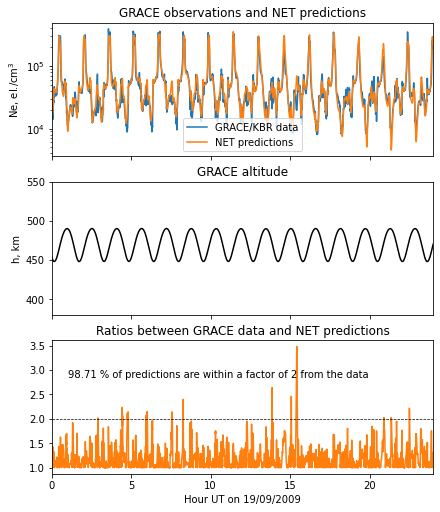

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(3,1, constrained_layout=True, figsize=(6,7), sharex=True)

axs[0].plot(example_df['hour_UT'].values, example_df['den_GRACE'].values, label='GRACE/KBR data')
axs[0].plot(example_df['hour_UT'].values, Ne_NET, label='NET predictions')
axs[0].set_yscale('log')
axs[0].legend()
axs[0].set_title('GRACE observations and NET predictions')
axs[0].set_ylabel('Ne, el./cm$^3$')

axs[1].plot(example_df['hour_UT'].values, example_df['Alt'].values, c='k')
axs[1].set_title('GRACE altitude')
axs[1].set_ylabel('h, km')
axs[1].set_ylim(380,550)

# Now let us compute ratios between model predictions and observations:
ratio = example_df['den_GRACE'].values/Ne_NET
ratio[ratio<1] = 1/ratio[ratio<1] # if the ratio <1, we take the inverted value (see Smirnov et al., 2023)
axs[2].plot(example_df['hour_UT'].values,ratio, c='C1')
axs[2].axhline(2, c='k', ls='--', lw=0.7)
axs[2].set_title('Ratios between GRACE data and NET predictions')
axs[2].set_xlim(0,24)
axs[2].set_xlabel('Hour UT on 19/09/2009')
axs[2].text(1,2.85,'{:.2f} % of predictions are within a factor of 2 from the data'.format(len(ratio[ratio<2])/len(ratio)*100))
fig.set_facecolor('w')